In [2]:
# Aaron Jiang

In [3]:
# import modules
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import re
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
%matplotlib inline
plt.style.use('fivethirtyeight')

In [4]:
# load and store relevant data
df = pd.read_csv('myruns.csv').dropna(axis=1)
df2 = pd.read_csv('arisruns.csv').dropna(axis=1)
df3 = pd.read_csv('henryruns.csv').dropna(axis=1)
df4 = pd.read_csv('anruns.csv').dropna(axis=1)
tempx = df.copy()
# unpack and drop bad columns
temp = sum(df.columns.str.extractall(r'(\w*\s*\w+[.]\d+$)').values.tolist(),[]) 
df = df.drop(columns=['Commute','Filename','Activity Name']).drop(columns=temp) 
# shorten redundant columns
df.columns = [re.search('\w+$',i).group() if 'Activity' in i else i for i in df.columns] 
# remove non-running entries
df = df.drop(index=df[df.Type != 'Run'].index).drop(columns=['Type','ID'])
# dates are off by 8 hours
dt = pd.to_datetime(df.Date).apply(lambda x: x.tz_localize('UTC'))  # for next step
df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
print('# of rows:',df.shape[0],'\n# of cols:',df.shape[1])
df3.sample(5)

# of rows: 197 
# of cols: 9


,Activity ID,Activity Date,Activity Name,Activity Type,Elapsed Time,Distance,Commute,Filename,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Elevation Low,Elevation High,Max Grade,Average Grade
31,3469553622,"May 18, 2020, 12:38:46 AM",Afternoon Run,Run,1987,3.50,False,activities/3469553622.gpx,1987.0,1284.0,3502.000000,3.9,15.000000,26.000000,4.0,-0.022844
32,3474785623,"May 19, 2020, 2:49:07 AM",running on a full stomach is not the move,Run,4351,5.60,False,activities/3474785623.gpx,4351.0,2180.0,5603.200195,4.1,22.799999,34.700001,6.5,0.010708
76,5041132568,"Mar 30, 2021, 11:06:38 PM",Afternoon Run,Run,2183,2.24,False,activities/5041132568.gpx,2183.0,723.0,2240.952148,8.4,48.299999,48.799999,0.5,0.004462
52,4131032046,"Sep 30, 2020, 2:16:47 AM",Evening Run,Run,2277,5.79,False,activities/4131032046.gpx,2277.0,2091.0,5798.100098,4.9,1.300000,5.100000,5.6,0.037943
74,4896582267,"Mar 5, 2021, 10:18:39 PM",Afternoon Run,Run,1183,3.24,False,activities/4896582267.gpx,1183.0,1178.0,3239.899902,3.8,320.600006,349.500000,4.3,0.006173


In [5]:
# UTC to PST/PDT
df.Date = dt.apply(lambda x: x.tz_convert('US/Pacific').strftime('%b %d, %Y, %r'))
# seconds to HH:MM
def convert(secs):
    return time.strftime('%H:%M:%S', time.gmtime(secs))
moving = df[['Moving Time','Distance']].copy()
df['Elapsed Time'] = df['Elapsed Time'].apply(lambda x: convert(x))
df['Moving Time'] = df['Moving Time'].apply(lambda x: convert(x))
# km to miles
df.Distance = df.Distance.apply(lambda x: np.round(x * 0.62137,2))
print('# of rows:',df.shape[0],'\n# of cols:',df.shape[1])
df.tail()


# of rows: 197 
# of cols: 9


,Date,Elapsed Time,Distance,Moving Time,Max Speed,Elevation Gain,Max Grade,Average Grade,Calories
200,"Apr 22, 2022, 09:02:31 PM",00:51:38,4.01,00:39:22,5.013332,0.0,0.000000,0.000000,490.513794
201,"Apr 26, 2022, 07:39:28 PM",01:02:58,4.02,00:38:27,3.521659,0.0,0.000000,-0.001757,434.524231
202,"Apr 30, 2022, 05:54:05 PM",01:01:27,5.01,00:47:52,4.176519,0.0,0.388526,0.001277,597.865967
203,"May 08, 2022, 05:11:32 PM",01:05:02,5.51,00:52:37,3.867788,0.0,0.000000,0.000000,614.655945
204,"May 12, 2022, 07:38:12 PM",01:11:10,4.50,00:44:25,4.103235,0.0,0.841167,-0.001378,554.085205


In [6]:
main = df.append(df2)
main = main.append(df3)
main = main.append(df4)
df4
#df.Pace.apply(lambda x: time.strftime('%H:%M:%S', time.gmtime(x)))


,Activity ID,Activity Date,Activity Name,Activity Type,Elapsed Time,Distance,Commute,Filename,Elapsed Time.1,Moving Time,...,Max Grade,Average Grade,Perceived Exertion,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,From Upload,Grade Adjusted Distance,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>"
0,6025544550,"Sep 27, 2021, 1:01:11 AM",lesss goo on a sundayy,Run,1856,5.95,False,activities/6025544550.gpx,1856.0,1801.0,...,7.500000,0.001681,6.0,0.0,47.0,0.0,1.0,5956.799805,0.0,3.205873
1,6060522321,"Oct 4, 2021, 1:51:34 AM",two regular show episodes,Run,1969,5.81,False,activities/6060522321.gpx,1969.0,1800.0,...,7.900000,0.000000,7.0,0.0,57.0,0.0,1.0,5820.200195,0.0,2.952362
2,6129485256,"Oct 18, 2021, 1:01:23 AM",half n episode of squid game,Run,1828,6.12,False,activities/6129485256.gpx,1828.0,1800.0,...,7.300000,-0.006528,7.0,0.0,57.0,0.0,1.0,6133.700195,0.0,3.352188
3,6162706995,"Oct 25, 2021, 1:19:16 AM",half n hour of run,Run,1800,6.24,False,activities/6162706995.gpx,1800.0,1800.0,...,6.766892,-0.006409,7.0,0.0,57.0,0.0,1.0,6247.100098,0.0,3.467339
4,6194918135,"Nov 1, 2021, 12:37:55 AM",run with bubby,Run,1952,4.99,False,activities/6194918135.gpx,1952.0,1800.0,...,7.258050,-0.002004,5.0,0.0,32.0,0.0,1.0,4995.299805,0.0,2.555917
5,6199065559,"Nov 1, 2021, 9:46:53 PM",MURPH on da 20th,Run,2759,3.22,False,activities/6199065559.gpx,2759.0,844.0,...,1.956947,-0.012417,8.0,0.0,36.0,0.0,1.0,3222.600098,0.0,1.167553
6,6258611832,"Nov 14, 2021, 7:14:46 PM",oh boi,Run,1856,6.18,False,activities/6258611832.gpx,1856.0,1800.0,...,6.423978,-0.009703,8.0,0.0,77.0,0.0,1.0,6188.799805,0.0,3.331660
7,6290091028,"Nov 21, 2021, 8:11:31 PM",air taste like ass fr,Run,1824,6.17,False,activities/6290091028.gpx,1824.0,1800.0,...,6.920439,-0.009720,7.0,0.0,57.0,0.0,1.0,6178.500000,0.0,3.384156
8,6348206961,"Dec 5, 2021, 7:29:44 PM",episode of wotakoi,Run,1799,6.10,False,activities/6348206961.gpx,1799.0,1799.0,...,7.601373,-0.006558,7.0,0.0,57.0,0.0,1.0,6104.700195,0.0,3.390272
9,6408515897,"Dec 20, 2021, 9:58:36 PM",to aaron's i go,Run,1197,3.77,False,activities/6408515897.gpx,1197.0,1164.0,...,4.716992,0.360341,7.0,0.0,37.0,0.0,1.0,3812.199951,0.0,3.153049


In [7]:
datelabel = dict(zip(df4['Activity Date'], range(len(df4['Activity Date']))))
df4['Activity Date'] = df4['Activity Date'].apply(lambda x: datelabel[x])


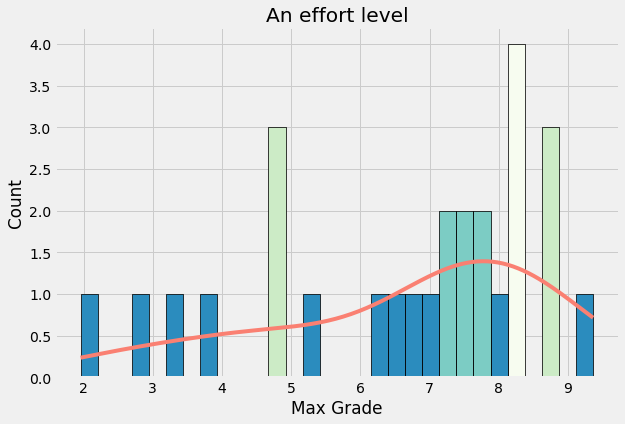

In [8]:
import seaborn as sns
fig = plt.figure(figsize=(9,6))

def coloring(n, patches):
    height = n / n.max()
    norm = clr.Normalize(height.min(),height.max())
    for bar_height, bar in zip(height, patches):
        bar.set_facecolor(plt.cm.get_cmap('GnBu_r')(norm(bar_height)))
plt.title('An effort level')
n, bins, patches = plt.hist(df4['Max Grade'], bins = 30, ec ='k')
coloring(n, patches)
sns.histplot()
sns.histplot(df4['Max Grade'],kde=True,color='salmon',bins=30,ec='k',alpha=0)

plt.show()

In [12]:
for i in df.Date:
    print(i)

Oct 15, 2017, 05:53:52 PM
Oct 21, 2017, 10:42:43 AM
Oct 22, 2017, 06:03:39 PM
Oct 23, 2017, 11:58:37 PM
Oct 25, 2017, 11:16:00 PM
Jun 26, 2018, 07:52:27 PM
Jun 27, 2018, 07:08:21 PM
Jul 12, 2018, 08:01:59 PM
Jul 19, 2018, 07:50:47 PM
Jul 23, 2018, 07:59:52 PM
Aug 05, 2018, 10:05:50 AM
Oct 03, 2018, 10:42:04 PM
Jul 10, 2019, 01:05:48 PM
Apr 25, 2020, 06:28:49 PM
Apr 27, 2020, 05:16:09 PM
Apr 28, 2020, 07:56:16 PM
May 03, 2020, 06:30:41 PM
May 04, 2020, 09:01:59 PM
May 06, 2020, 07:52:50 PM
May 07, 2020, 08:47:17 PM
May 08, 2020, 07:45:24 PM
May 10, 2020, 07:29:37 PM
May 12, 2020, 07:56:29 PM
May 14, 2020, 09:17:23 PM
May 16, 2020, 09:24:25 PM
May 17, 2020, 05:38:39 PM
May 19, 2020, 07:51:32 PM
May 21, 2020, 06:41:26 PM
May 22, 2020, 04:29:24 PM
May 28, 2020, 07:54:15 PM
May 29, 2020, 08:21:29 PM
May 31, 2020, 07:49:04 PM
Jun 07, 2020, 11:17:22 AM
Jun 08, 2020, 07:53:01 PM
Jun 09, 2020, 09:25:20 PM
Jun 11, 2020, 09:44:53 PM
Jun 22, 2020, 08:50:44 PM
Jun 25, 2020, 08:41:54 PM
Jul 01, 2020